In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [340]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import sys
sys.path.append("../../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators
from src.util import noise_generator

## [N-1/N] PDS scheme

In [268]:
# performs the [N-1/N] PDS scheme
def PSD_Nm1_N(N, mode='fermi'):
    # compute bs
    if mode=='fermi':
        b = 2*np.arange(1, 2*N+2) - 1
    else:
        b = 2*np.arange(1, 2*N+2) + 1
    # compute xi
    lam = np.zeros((2*N, 2*N), dtype=float)
    for m in range(2*N):
        if m > 0:
            lam[m, m-1] = 1/np.sqrt(b[m]*b[m-1])
        if m < 2*N-1:
            lam[m, m+1] = 1/np.sqrt(b[m]*b[m+1])
    w, _ = np.linalg.eig(lam)
    xi = 2/np.sort(w)[N:]
    # compute sigma
    lam = lam[1:, 1:]
    sigma = []
    if lam.size > 1:
        w, _ = np.linalg.eig(lam)
        sigma = 2/np.sort(w)[N:]
    # compute eta
    etas = []
    for j in range(N):
        eta = 0.5*N*b[N]
        if (len(sigma) > 0):
            eta *= np.prod(sigma**2-xi[j]**2)
        for k in range(N):
            if k != j:
                eta /= (xi[k]**2-xi[j]**2)
        etas.append(eta)
    return xi, etas

In [149]:
# test with [0/1]
xi, etas = PSD_Nm1_N(1)
print("xi:", xi[0], "should be", np.sqrt(12))
print("eta:", etas[0], "should be", 1.5)

xi: 3.4641016151377535 should be 3.4641016151377544
eta: 1.5 should be 1.5


In [151]:
# test with [1/2]
xi_1 = np.sqrt(90 + np.sqrt(6420))
xi_2 = np.sqrt(90 - np.sqrt(6420))
eta_1 = 5*(xi_1**2-42)/(2*(xi_1**2-90))
eta_2 = 5*(xi_2**2-42)/(2*(xi_2**2-90))
xi, etas = PSD_Nm1_N(2)
print("xi_1", xi[0], "should be", xi_1)
print("xi_2", xi[1], "should be", xi_2)
print("eta_1", etas[0], "should be", eta_1)
print("eta_2", etas[1], "should be", eta_2)

xi_1 13.043193723012802 should be 13.0431937230128
xi_2 3.142466786452878 should be 3.1424667864528786
eta_1 3.9976617288979543 should be 3.9976617288979535
eta_2 1.0023382711020448 should be 1.0023382711020465


## [N/N] PDS scheme

In [269]:
# performs the [N/N] PDS scheme
def PSD_N_N(N, mode='fermi'):
    # compute bs
    if mode=='fermi':
        b = 2*np.arange(1, 2*N+2) - 1
    else:
        b = 2*np.arange(1, 2*N+2) + 1
    # compute xi
    lam = np.zeros((2*N+1, 2*N+1), dtype=float)
    for m in range(2*N+1):
        if m > 0:
            lam[m, m-1] = 1/np.sqrt(b[m]*b[m-1])
        if m < 2*N:
            lam[m, m+1] = 1/np.sqrt(b[m]*b[m+1])
    w, _ = np.linalg.eig(lam)
    xi = 2/np.sort(w)[N+1:]
    # compute sigma
    lam = lam[1:, 1:]
    sigma = []
    if lam.size > 1:
        w, _ = np.linalg.eig(lam)
        sigma = 2/np.sort(w)[N:]
    # compute eta
    etas = []
    for j in range(N):
        eta = 0.5/(4*(N+1)*b[N])
        if (len(sigma) > 0):
            eta *= np.prod(sigma**2-xi[j]**2)
        for k in range(N):
            if k != j:
                eta /= (xi[k]**2-xi[j]**2)
        etas.append(eta)
    return xi, etas

In [167]:
# test with [0/1]
xi, etas = PSD_N_N(1)
print("xi:", xi[0], "should be", np.sqrt(10))
print("eta:", etas[0], "should be", 25/24)

xi: 3.162277660168377 should be 3.1622776601683795
eta: 1.0416666666666674 should be 1.0416666666666667


In [168]:
# test with [2/2]
xi_1 = np.sqrt(56 + np.sqrt(2128))
xi_2 = np.sqrt(56 - np.sqrt(2128))
eta_1 = (xi_1**4-420*xi_1**2+15120)/(240*(56-xi_1**2))
eta_2 = (xi_2**4-420*xi_2**2+15120)/(240*(56-xi_2**2))
xi, etas = PSD_N_N(2)
print("xi_1", xi[0], "should be", xi_1)
print("xi_2", xi[1], "should be", xi_2)
print("eta_1", etas[0], "should be", eta_1)
print("eta_2", etas[1], "should be", eta_2)

xi_1 10.105951235716669 should be 10.105951235716665
xi_2 3.141615766021815 should be 3.1416157660218116
eta_1 1.5665892567112163 should be 1.5665892567112127
eta_2 1.0000774099554497 should be 1.0000774099554541


## [N+1/N] PDS scheme

In [219]:
# performs the [N+1/N] PDS scheme
def PSD_Np1_N(N):
    # compute bs
    b = 2*np.arange(1, 2*N+3) - 1
    # compute ds
    d = [1/4/b[0]]
    for i in range(2, 2*N+3):
        if (i % 2 == 0):
            # i == 2*m
            m = i//2
            d.append(-4*m**2*b[m-1]**2*b[i-1]**2)
        else:
            # i == 2*m+1
            m = (i-1)//2
            d.append(-b[i-1]/(4*m*(m+1)*b[m-1]*b[m]))
    # Compute RN and TN
    TN = 1/(4*np.sum(d[1:2*N+2:2]))
    RN = 0
    for m in range(1, N+2):
        temp = 0
        for k in range(m, N+2):
            temp += d[2*k-1]
        RN += d[2*m-2]*temp**2
    RN *= (4*TN)**2
    # Compute xi
    lam = np.zeros((2*N+1, 2*N+1), dtype=float)
    for m in range(2*N+1):
        if m > 0:
            lam[m, m-1] = 1/np.sqrt(d[m+1]*d[m])
        if m < 2*N:
            lam[m, m+1] = 1/np.sqrt(d[m+1]*d[m+2])
    # Compute eta using the recursive algorithm
    etas = []
    for j in range(1, N+1):
        

SyntaxError: unexpected EOF while parsing (<ipython-input-219-4ce000a581c4>, line 35)

In [220]:
PSD_Np1_N(2)

[[0.         0.36514837 0.         0.         0.        ]
 [0.36514837 0.         0.02608203 0.         0.        ]
 [0.         0.02608203 0.         0.07529233 0.        ]
 [0.         0.         0.07529233 0.         0.01916532]
 [0.         0.         0.         0.01916532 0.        ]]


# Testing

In [321]:
def f_Fermi(x):
    return 1/(1+np.exp(x))

def f_Bose(x):
    return np.exp(-x)/(1-np.exp(-x))

In [468]:
N = 1000
xs_fermi = np.linspace(-4, 4, N)
fs_fermi = f_Fermi(xs_fermi)
xs_bose = np.linspace(-4, 4, N)
fs_bose = f_Bose(xs_bose)

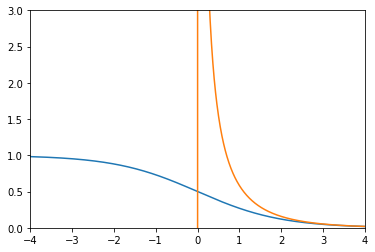

In [469]:
plt.plot(xs_fermi, fs_fermi)
plt.plot(xs_bose, fs_bose)
plt.xlim(-4, 4)
plt.ylim(0, 3)
plt.show()

In [470]:
xi, etas = PSD_N_N(15)
fs_approx = []
for x in xs_fermi:
    temp = np.sum(2*np.array(etas)*x/(x**2+xi**2))
    fs_approx.append(0.5-temp)

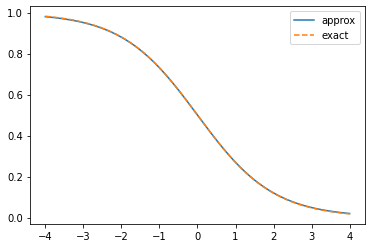

In [471]:
plt.plot(xs_fermi, fs_approx, label="approx")
plt.plot(xs_fermi, fs_fermi, "--", label="exact")
plt.legend()
plt.show()

In [472]:
xi, etas = PSD_N_N(20, "bose")
fs_approx = []
for x in xs_bose:
    temp = np.sum(2*np.array(etas)*x/(x**2+xi**2))
    fs_approx.append(np.exp(-x)*(1/x+0.5+temp))

In [473]:
fs_coths = 0.5*(1/np.tanh(xs_bose/2)-1)
fs_bose_2 = 1/(np.exp(xs_bose)-1)

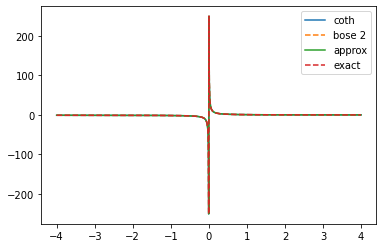

In [474]:
plt.plot(xs_bose, fs_coths, label="coth")
plt.plot(xs_bose, fs_bose_2, "--", label="bose 2")
plt.plot(xs_bose, fs_approx, label="approx")
plt.plot(xs_bose, fs_bose, "--", label="exact")
plt.legend()
#plt.ylim(0, 3)
plt.show()

In [677]:
def get_pade_coefficients(N, beta, gamma, eta):
    xij, etaj = PSD_Nm1_N(N-1, "bose")
    gs = [1/(gamma*beta) - 1.j/2]
    for j in range(N-1):
        gs[0] -= 2*etaj[j]*gamma*beta/(xij[j]**2 - gamma**2*beta**2)
    gs[0] *= eta*gamma #*np.exp(-1.j*gamma*beta)
    ws = [gamma]
    for k in range(N-1):
        gs.append(2*etaj[k]*eta*gamma*xij[k]/(xij[k]**2-gamma**2*beta**2))#*np.exp(-1.j*xij[k]))
        ws.append(xij[k]/beta)
    return np.array(gs), np.array(ws)

In [678]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 50.0
T = 1/beta
gamma = 5.0
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 3

gs_compare, ws_compare = debye_spectral_density.get_debye_coefficients(10000, T, gamma, eta)

In [730]:
gs, ws = get_pade_coefficients(15, beta, gamma, eta)

In [731]:
taus = np.linspace(0, 15, 1000)
alphas = bath_correlation_function.alpha(taus, gs, ws)
alphas_compare = bath_correlation_function.alpha(taus, gs_compare, ws_compare)

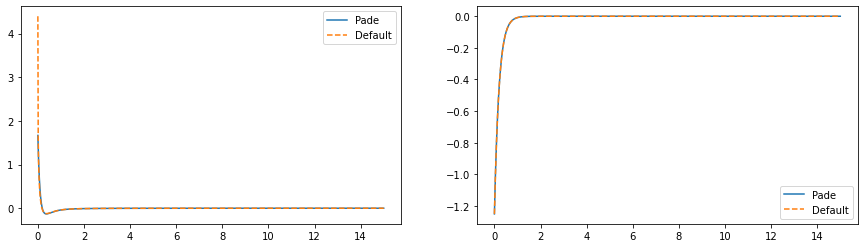

In [732]:
figure, axarray = plt.subplots(1, 2, figsize=(15,4))
axarray[0].plot(taus, np.real(alphas), label="Pade")
axarray[0].plot(taus, np.real(alphas_compare), "--", label="Default")
axarray[0].legend()
axarray[1].plot(taus, np.imag(alphas), label="Pade")
axarray[1].plot(taus, np.imag(alphas_compare), "--", label="Default")
axarray[1].legend()
plt.show()

# debugging pade decomp

In [647]:
N = 40
xij, etaj = PSD_Nm1_N(N, "bose")

In [650]:
def bose_approx(xs):
    fs_approx = []
    temp = 0
    for k in range(N):
        temp += 2*etaj[k]*xs/(xs**2+xij[k]**2)
    #for x in xs:
    #    temp = np.sum(2*np.array(etas)*x/(x**2+xi**2))
    #    fs_approx.append(1/x+0.5+temp)
    return 1/xs + 0.5 + temp

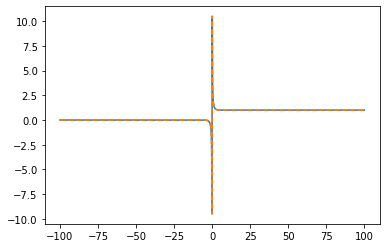

In [651]:
xs = np.linspace(-100, 100, 1000)
plt.plot(xs, bose_approx(xs))
plt.plot(xs, 1/(1-np.exp(-xs)), "--")
plt.show()

In [664]:
def integrand(w, tau):
    #S = eta*gamma*w/(w**2+gamma**2)
    #temp = 1/(w*beta) + 0.5
    #temp = 0
    #for j in range(N-1):
    #    temp += 2*etaj[j]*w*beta/((w*beta)**2 + xij[j]**2)
    #result = np.exp(1.j*w*tau)*np.exp(-w*beta)*S*temp/np.pi
    #return result
    
    f_bose = 0
    for k in range(N):
        f_bose += 2*etaj[k]*w*beta/(w**2*beta**2+xij[k]**2)
    f_bose += 1/(w*beta) + 0.5
    S = eta*gamma*w/(w**2+gamma**2)
    f_bose = bose_approx(w*beta)
    
    result = S*np.exp(1.j*w*tau)*np.exp(-w*beta)*f_bose/np.pi
    return result

In [665]:
def integrand_old(w, tau):
    S = eta*gamma*w/(w**2+gamma**2)
    result = S*np.exp(1.j*w*tau)/(np.exp(w*beta)-1)/np.pi
    return result

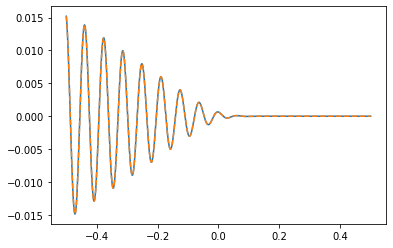

In [666]:
ws = np.linspace(-0.5, 0.5, 1000)
tau = 100
plt.plot(ws, np.real(integrand(ws, tau)))
plt.plot(ws, np.real(integrand_old(ws, tau)), "--")
plt.show()

In [ ]:
taus = np.linspace(0, 30, 100)
